In [24]:
import numpy as np
import serial, time
import matplotlib.pyplot as plt
from IPython import display
import datetime
%matplotlib inline
import pandas as pd

In [38]:
def open_serial(port, baudrate=None):
    if baudrate == None:
        try:
            return serial.Serial(port)
        except Exception as e:
            print(e)
            return None
    else:
        try:
            return serial.Serial(port, baudrate)
        except Exception as e:
            print(e)
            return None
        
def close_serial(*devices):
    for device in devices:
        try:
            device.close()
        except Exception as e:
            print(e)

def turn_curtain(curtain_device, angle, TEST = False):
    if TEST:
        # заглушка для тестирования
        print(f'the curtain turned at an {angle}')
    else:
        try:
            command = str(angle)
            time.sleep(10)
            curtain_device.write(command.encode('utf-8'))
            time.sleep(10)
        except Exception as e:
            print(e)

def d_action(d_device, TEST = False):
    if TEST:
        # заглушка для тестирования
        print('d action')
    else:
        try:
            values = bytes.fromhex('111140014400000000001111400153000A0000001111400150004600000011114001470000000000')
            d_device.write(values)
        except Exception as e:
            print(e)

def read_counts(counter_device, TEST = False):
    if TEST:
        # заглушка для тестирования
        return np.random.randint(low=0, high=100, size=3)
    else:
        try:
            raw_reading = counter_device.readline().decode(errors='ignore')
            return [int(part.strip()) for part in raw_reading.split('\t')] 
        except Exception as e:
            print(e)
            return None
        
def read_power(powermeter_device, TEST=False):
    if TEST:
        # заглушка для тестирования
        return np.random.random()
    else:
        try:
            powermeter_device.write(b'*CVU')
            return powermeter_device.readline().decode().strip()
        except Exception as e:
            print(e)
            return None

In [20]:
s = open_serial('COM25', 115200)
curtain = open_serial('COM4', 9600)
d = open_serial('COM23')
maestro = open_serial('COM17', 115200)

close_serial(s, curtain, d, maestro)

module 'serial' has no attribute 'Serial'
module 'serial' has no attribute 'Serial'
module 'serial' has no attribute 'Serial'
module 'serial' has no attribute 'Serial'
'NoneType' object has no attribute 'close'
'NoneType' object has no attribute 'close'
'NoneType' object has no attribute 'close'
'NoneType' object has no attribute 'close'


the curtain turned at an 90
the curtain turned at an 0


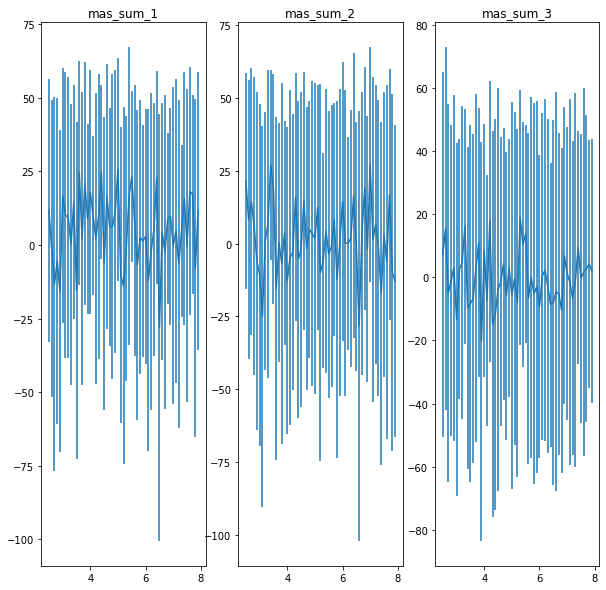

d action


In [40]:
length = 10 # количество усреднений

FLAG = True # в режиме тестирования

data = pd.DataFrame(columns=['diaphragm',
                             'mas_sum_1', 'errors_1',
                             'mas_sum_2', 'errors_2',
                             'mas_sum_3', 'errors_3',
                             'power_abs', 'power_rel'])

for i in range(55):    
    display.clear_output(wait=True)

    data.loc[i, 'diaphragm'] = 2.5 + 0.1 * i

    # измерение шумов

    turn_curtain(curtain, 90, TEST=FLAG)

    noise_counts = np.zeros(3, dtype=int)
    for _ in range(length):
        noise_counts = noise_counts + read_counts(s, TEST=FLAG) / length
    data.loc[i, ['errors_1', 'errors_2', 'errors_3']] = noise_counts

    # измерение счетов

    turn_curtain(curtain, 0, TEST=FLAG)

    if i == 0:
        init_power = 0
        for _ in range(length):
            init_power += read_power(maestro, TEST=FLAG) / length
    
    abs_power = 0 
    true_counts = np.zeros(3, dtype=int)
    for _ in range(length):
        true_counts = true_counts + read_counts(s, TEST=FLAG) / length
        abs_power += read_power(maestro, TEST=FLAG) / length
    true_counts = (true_counts - noise_counts) / ( abs_power / init_power)

    data.loc[i, ['mas_sum_1', 'mas_sum_2', 'mas_sum_3']] = true_counts
    data.loc[i, ['power_abs', 'power_rel']] = abs_power, ( abs_power / init_power )

    # построение графиков

    fig, axs = plt.subplots(1, 3, figsize=(10, 10))

    for j in range(1, 4):
        ax = axs[j-1]
        ax.errorbar(data['diaphragm'],
                     data[f'mas_sum_{j}'],
                     yerr=data[f'errors_{j}'])
        ax.set_title(f'mas_sum_{j}')
    plt.show()
        
    d_action(d, TEST=FLAG)

now = datetime.datetime.now()
filename = 'result_{}.csv'.format(now.strftime('%Y-%m-%d_%H-%M-%S'))
data.to_csv(filename, index=False)